In [1]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from PIL import Image
import time
import cv2
from itertools import count
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import clear_output

import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.optim as optim
import torch.nn.functional as F

In [2]:
env = gym.make('CartPole-v1').unwrapped

In [3]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Replay Memory
Transition = namedtuple('Transition', ('state','action', 'next_state', 'reward'))
class exp_replay(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory)<self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position= (self.position+1)%self.capacity
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):
    
    def __init__(self, h, w, num_actions = 2):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 5, stride = 2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        
        self.fc4 = nn.Linear(linear_input_size, 512)
        self.fc5 = nn.Linear(512, num_actions)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.bn2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.bn3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        action = self.fc5(x)
        return action

In [6]:
env.reset()
screen = env.render(mode = 'rgb_array').transpose((2,0,1))
print(env.x_threshold)
print(screen.shape)
time.sleep(1)
env.close()

2.4
(3, 400, 600)


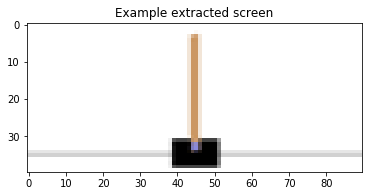

In [7]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold*2
    scale = screen_width/world_width
    return int(env.state[0]*scale + screen_width/2.0)  # Middle of cart

def get_screen():
    # environment returns screen of size (400,600,3).
    #Torch order is (C,H,W).
    screen = env.render(mode = 'rgb_array').transpose((2,0,1))
    env.close()
    
    # we do not need to consider whole frame. since cart pole is only in lower half of frame
    # we trim the not useful part of frame
    screen_channel, screen_height, screen_width = screen.shape
    
    # triming of height
    screen = screen[:, int(screen_height*0.4):int(screen_height*0.8)]
    view_width = int(screen_width*0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location<view_width//2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    #Triming of width
    screen = screen[:,:,slice_range]
    
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255    #conversion to float
    screen = torch.from_numpy(screen)             # Conversion to tensor
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [8]:
BATCH_SIZE = 64
GAMMA = 0.999
EPSILON_START = 1
EPSILON_END = 0.01
EPS_DECAY = 0.005
TARGET_UPDATE = 10

# Get screen shape to initialize layers correctly. After we trimed unuseful data from environment,
# we get shape 3x40x90

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Actions allowed by environment are obtained
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = exp_replay(20000)

steps = 0
def greedy_policy_action(state):
    global steps
    sample = random.random()
    eps_threshold = EPSILON_END + (EPSILON_START - EPSILON_END) * \
        math.exp(-1. * steps / EPS_DECAY)
    steps +=1
    
    if sample>eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1,1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device = device, dtype= torch.long)
    

episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001) # pause a bit so that plots are updated
    if is_ipython:
        #isplay.clear_output(wait=True)
        display.display(plt.gcf())

In [9]:
def optimize():
    if len(memory)< BATCH_SIZE:
        return 0
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    
    non_final_mask = torch.tensor(tuple(map(lambda s:s is not None, batch.next_state)), device = device, dtype = torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
        
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
     # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    
    next_state_values = torch.zeros(BATCH_SIZE, device = device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    #compute the expected Q-values
    expected_state_action_values = (next_state_values*GAMMA)+reward_batch
    
    # compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    #optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1,1)
    optimizer.step()
    return loss.item()

In [10]:
def plot(episode, avg_loss, episode_durations):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Episode: %5d | Duration %5.2f'%(episode, np.mean(episode_durations[-10:])))
    plt.plot(episode_durations)
    plt.subplot(132)
    plt.title('loss | Average Loss: %5.2f'%np.mean(ep_loss[-10:]))
    plt.plot(ep_loss)
    plt.show()

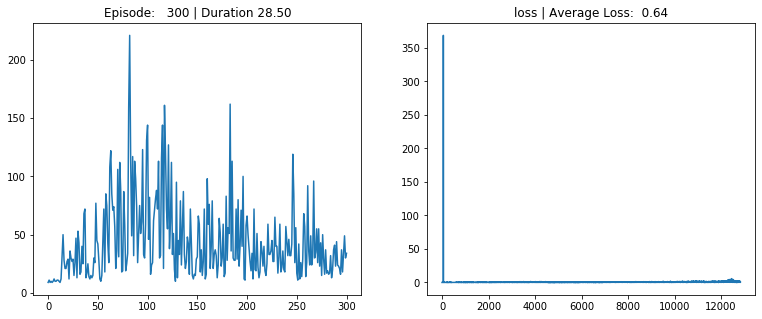

In [ ]:
num_episodes = 500
ep_loss = np.array([])
for i_episode in range (num_episodes):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        #select and perform the action
        
        action = greedy_policy_action(state)
        _,reward,done,_ = env.step(action.item())
        reward = torch.tensor([reward], device = device)
        
        # observe new state
        last_screen = current_screen
        current_screen = get_screen()
        
        if not done:
            next_state = current_screen-last_screen
        else:
            next_state = None
            
        #store the transition in Memory
        
        memory.push(state, action, next_state, reward)
        
        #move to next state
        state = next_state
        
        #perform one step optimization ( on target network)
        loss = optimize()
        if done:
            episode_durations.append(t+1)
            break
            
            
        ep_loss = np.append(ep_loss, loss)    
    if i_episode%10==0:
        plot(i_episode, ep_loss, episode_durations)
        
        
    # Update the target network, copying all wirght and biases in DQN
    if i_episode% TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
print('Complete')
env.close()
plt.ioff()
plt.show()


In [ ]:
durations_t = torch.tensor(episode_durations, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())